# Generate SMILES Strings of Cofactors

#### Importing Necessary Packages

In [1]:
from rdkit import Chem 
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdqueries
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdDepictor
from rdkit import Geometry
rdDepictor.SetPreferCoordGen(True)
import itertools, random
import os, rdkit
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Descriptors

#### Creating a Function to "Stitch Together" our Cofactors

In [2]:
def enumerate_all_products(core,*rgroups,randomOrder=False):
    # preserve the positions of the non-dummy core atoms, 
    # we will use these to make sure the cores are drawn
    # the same way in each molecule we generate
    corePos = {}
    conf = core.GetConformer()
    for i in range(conf.GetNumAtoms()):
        corePos[i] = Geometry.Point2D(conf.GetAtomPosition(i))
        
    # Python's itertools handles doing the combinatorics of generating
    # every possible combination of R groups:
    order = itertools.product(*rgroups)
    if randomOrder:
        order = list(order)
        random.shuffle(order)
        
    # now we just loop over each combination, copy all the pieces into
    # one molecule, and zip it. That's our product
    for tpl in order:
        tm = Chem.RWMol(core)
        for r in tpl:
            tm.InsertMol(r)
        prod = Chem.molzip(tm)
        if prod is not None:
            # generate 2d coordinates with the core fixed in place
            rdDepictor.Compute2DCoords(prod,canonOrient=False,coordMap=corePos)
            
            # and finally yield the product molecule
            yield prod

#### Creating the Pyridinium Core for our (oxidized) Cofactors

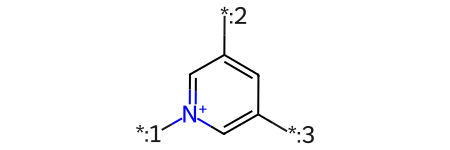

In [3]:
core_smi = '[*:3]C1=C[N+]([*:1])=CC([*:2])=C1' #smiles string for our pyridinium core with 3 substitution positions
core = Chem.MolFromSmiles(core_smi)

rdDepictor.SetPreferCoordGen(True)
rdDepictor.Compute2DCoords(core)
core #showing the structure we use as our core

#### Generating Lists of Possible Substituents to the Core

In [11]:
sub_smis_R1 = ['C([*:1])','CCCC([*:1])', 'CCCCCCCC([*:1])', 'C([*:1])CCCO', 'C1=CC=CC=C1([*:1])', 'OC1=CC=C([*:1])C=C1', 
               'C1=CC=C(C([*:1]))C=C1', 'C1=CC=C(CC([*:1]))C=C1', 'C1=CC=C(CCC([*:1]))C=C1', '[*:1]CCC1=CC=C(C([O-])=O)C=C1', 'C1=CC=C(CCCCC([*:1]))C=C1']
# R1-substituents
# MNA+, BuNA+, OcNA+, BuOHNA+, PNA+, HPNA+, BNA+, P2NA+, P3NA+, B2NA+, P5NA+

sub_smis_R2 = ['C([*:2])(N)=O','C([*:2])#N', 'C([*:2])([O-])=O', 'C([*:2])(C)=O', 'C([*:2])([H])=O', 'C([*:2])(OC)=O']
# R2-substituents
# CONH2, CN, COO-, COCH3, CHO, COOCH3

sub_smis_R3 = ['[H]([*:3])','C([*:3])']
# R5-substituents
# H, Me

# turning SMILES substituents into mol objects using RDKit
substs_1 = [Chem.MolFromSmiles(smi) for smi in sub_smis_R1]
substs_2 = [Chem.MolFromSmiles(smi) for smi in sub_smis_R2]
substs_3 = [Chem.MolFromSmiles(smi) for smi in sub_smis_R3]

[13:32:34] WARNING: not removing hydrogen atom with dummy atom neighbors


#### Systematically Creating the Substituted Cofactors

In [12]:
prod_gen = []
rdDepictor.SetPreferCoordGen(True)
rdDepictor.Compute2DCoords(core)
# combinatorially adding all possible substituents to appropriate positions
prod_gen += enumerate_all_products(core, substs_1, substs_2, substs_3)

# removing any duplicate products 
nicotinamides = []
seen = set()
for prod in prod_gen:
    if prod is not None:
        Chem.SanitizeMol(prod)
        smi = Chem.MolToSmiles(prod)
        if smi not in seen:
            nicotinamides.append(prod)
            seen.add(smi)


#### Adding Atom Numbers to Cofactor Images/Drawings

Number of BMCs Generated: 132


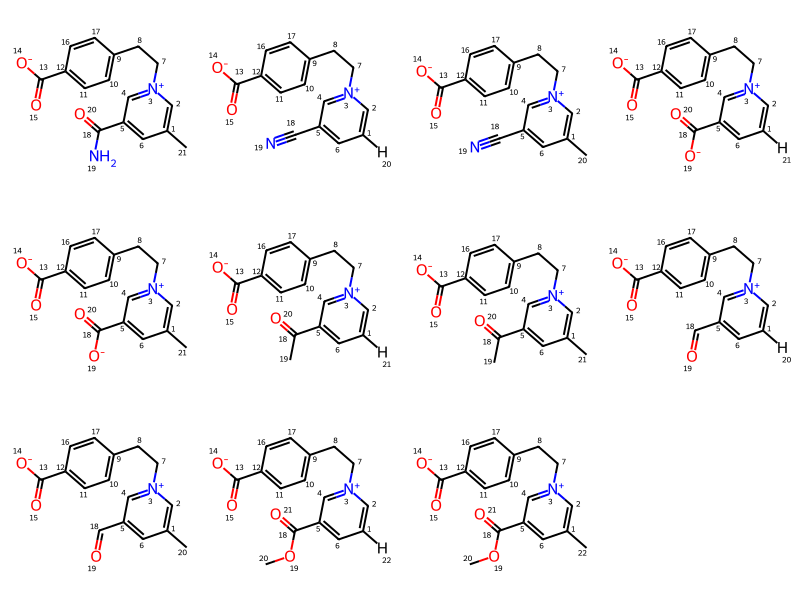

In [13]:
for mol in nicotinamides:
    for i, atom in enumerate(mol.GetAtoms()):
        # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
        atom.SetProp("atomNote", str(atom.GetIdx()+1))

# showing how many cofactors we have generated
print(F'Number of BMCs Generated: {len(nicotinamides)}')

# Visualizing some of the generated BMCs (with atom numbers)
Draw.MolsToGridImage(nicotinamides[109:120],molsPerRow=4) # can adjust range of nicotinamides to show more

#### Creating Lists of Substituents for the Natural Cofactor Analog NMN+, Generating the Natural Cofactors, and Adding Atom Numbers to the Natural Cofactor Images/Drawings

In [7]:
# # Only necessary if planning to incorporate natural cofactors into calculations
# nat_sub_smis_R1 = ['[*:1][C@@H]1O[C@H](COP(O)([O-])=O)[C@@H](O)[C@H]1O', '[*:1][C@@H]1O[C@H](COP([O-])([O-])=O)[C@@H](O)[C@H]1O']
# # nmn+ (-1), nmn+ (-2)
# nat_sub_smis_R2 = ['C([*:2])(N)=O']
# # CONH2
# nat_sub_smis_R3 = ['[H]([*:3])']
# # H

# nat_substs_1 = [Chem.MolFromSmiles(smi) for smi in nat_sub_smis_R1]
# nat_substs_2 = [Chem.MolFromSmiles(smi) for smi in nat_sub_smis_R2]
# nat_substs_3 = [Chem.MolFromSmiles(smi) for smi in nat_sub_smis_R3]

# # Create the substituted nicotinamides
# nat_prod_gen = []
# rdDepictor.SetPreferCoordGen(True)
# rdDepictor.Compute2DCoords(core)
# nat_prod_gen += enumerate_all_products(core, nat_substs_1, nat_substs_2, nat_substs_3)

# # remove any duplicate products 
# nat_nicotinamides = []
# seen = set()
# for prod in nat_prod_gen:
#     if prod is not None:
#         Chem.SanitizeMol(prod)
#         smi = Chem.MolToSmiles(prod)
#         if smi not in seen:
#             nat_nicotinamides.append(prod)
#             seen.add(smi)

# # Add atom numbers to the images
# for mol in nat_nicotinamides:
#     for i, atom in enumerate(mol.GetAtoms()):
#         # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
#         atom.SetProp("atomNote", str(atom.GetIdx()+1))

# Draw.MolsToGridImage(nat_nicotinamides,molsPerRow=2)

#### Creating a Dataframe for the Natural Cofactor Analog Structures

In [8]:
# # creating an empty dataframe
# natural = pd.DataFrame()

# # Generate IDs
# natural['code_name'] = ['NMNH_1-_pyridinium', 'NMNH_2-_pyridinium'] # common names since there are only two shown here, see BMC section for large sets

# # Convert the nicotinamide mol objects to a list of smiles and grab the total charge/multiplicity/number of unpaired electrons
# natural['SMILES'] = [Chem.MolToSmiles(mol) for mol in nat_nicotinamides]
# natural['charge'] = [Chem.rdmolops.GetFormalCharge(mol) for mol in nat_nicotinamides]
# natural['multiplicity'] = [(Chem.Descriptors.NumRadicalElectrons(mol)+1) for mol in nat_nicotinamides]
# natural['unpaired'] = [(Chem.Descriptors.NumRadicalElectrons(mol)) for mol in nat_nicotinamides]

# # This adds the mol object as a column - useful for visualization in Jupyter Notebooks
# PandasTools.AddMoleculeColumnToFrame(natural, smilesCol='SMILES')
# natural

#### Creating a Dataframe for the BMCs

,code_name,SMILES,charge,multiplicity,unpaired,ROMol
0,BMC_001_pyridinium,[H]c1cc(C(N)=O)c[n+](C)c1,1,1,0,
1,BMC_002_pyridinium,Cc1cc(C(N)=O)c[n+](C)c1,1,1,0,
2,BMC_003_pyridinium,[H]c1cc(C#N)c[n+](C)c1,1,1,0,
3,BMC_004_pyridinium,Cc1cc(C#N)c[n+](C)c1,1,1,0,
4,BMC_005_pyridinium,[H]c1cc(C(=O)[O-])c[n+](C)c1,0,1,0,
...,...,...,...,...,...,...
127,BMC_128_pyridinium,CC(=O)c1cc(C)c[n+](CCCCCc2ccccc2)c1,1,1,0,
128,BMC_129_pyridinium,[H]c1cc(C=O)c[n+](CCCCCc2ccccc2)c1,1,1,0,
129,BMC_130_pyridinium,Cc1cc(C=O)c[n+](CCCCCc2ccccc2)c1,1,1,0,
130,BMC_131_pyridinium,[H]c1cc(C(=O)OC)c[n+](CCCCCc2ccccc2)c1,1,1,0,

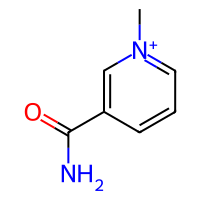
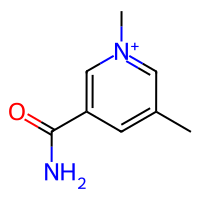
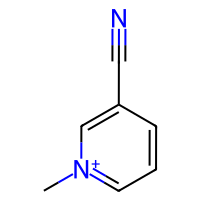
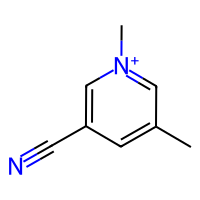
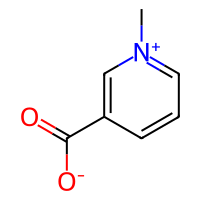
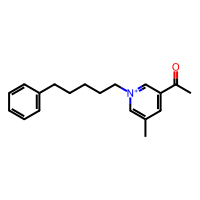
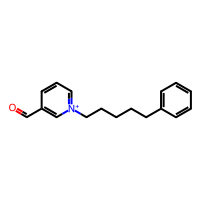
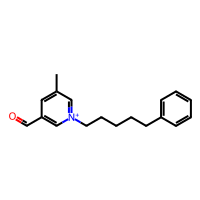
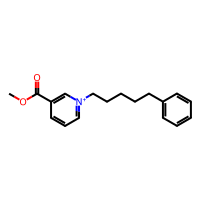
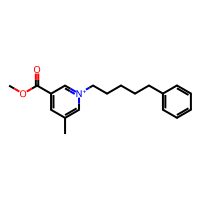

In [14]:
# BMCs = pd.DataFrame()

# # Generate IDs
# padding = 3
# BMCs['code_name'] = ['BMC_'+str(str(i+1).zfill(padding)+'_pyridinium') for i in range(0,len(nicotinamides))] # for high-throughput naming
# # 'code-name' column heading is useful for using AQME for initial conformer generation

# # Convert the nicotinamide mol objects to a list of smiles and grab the total charges
# BMCs['SMILES'] = [Chem.MolToSmiles(mol) for mol in nicotinamides]
# BMCs['charge'] = [Chem.rdmolops.GetFormalCharge(mol) for mol in nicotinamides]
# BMCs['multiplicity'] = [(Chem.Descriptors.NumRadicalElectrons(mol)+1) for mol in nicotinamides]
# BMCs['unpaired'] = [(Chem.Descriptors.NumRadicalElectrons(mol)) for mol in nicotinamides]

# # This adds the mol object as a column - useful for visualization in Jupyter Notebooks
# PandasTools.AddMoleculeColumnToFrame(BMCs, smilesCol='SMILES')
# BMCs

,code_name,SMILES,charge,multiplicity,unpaired,ROMol
0,A1a,[H]c1cc(C(N)=O)c[n+](C)c1,1,1,0,
1,A1b,Cc1cc(C(N)=O)c[n+](C)c1,1,1,0,
2,A2a,[H]c1cc(C#N)c[n+](C)c1,1,1,0,
3,A2b,Cc1cc(C#N)c[n+](C)c1,1,1,0,
4,A5a,[H]c1cc(C(=O)[O-])c[n+](C)c1,0,1,0,
...,...,...,...,...,...,...
127,I3b,CC(=O)c1cc(C)c[n+](CCCCCc2ccccc2)c1,1,1,0,
128,I4a,[H]c1cc(C=O)c[n+](CCCCCc2ccccc2)c1,1,1,0,
129,I4b,Cc1cc(C=O)c[n+](CCCCCc2ccccc2)c1,1,1,0,
130,I6a,[H]c1cc(C(=O)OC)c[n+](CCCCCc2ccccc2)c1,1,1,0,

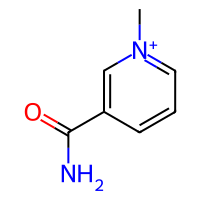
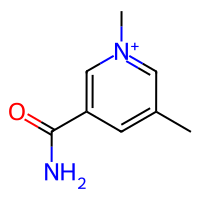
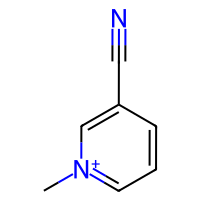
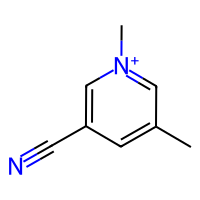
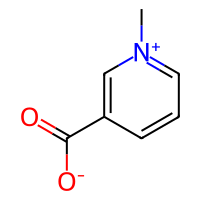
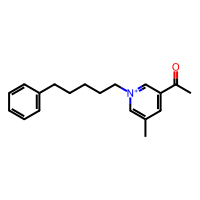
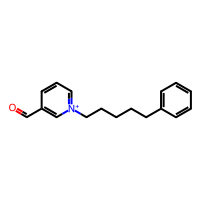
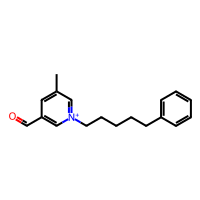
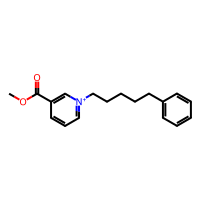
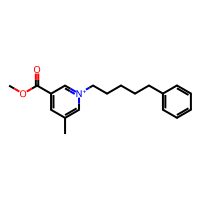

In [16]:
BMCs = pd.DataFrame()

# # Generate IDs
# padding = 3
# BMCs['code_name'] = ['BMC_'+str(str(i+1).zfill(padding)+'_pyridinium') for i in range(0,len(nicotinamides))] # for high-throughput naming
# # 'code_name' column heading is useful for using AQME for initial conformer generation

# naming bmcs to match new convention
r1 = ['A','B','D','C','E','J','F','G','H','K','I'] # listing substituents in the order they appear in the list of SMILES strings
r2 = ['1','2','5','3','4','6']
r3 = ['a','b']

names = []

for i in r1:
    for j in r2:
        for k in r3:
            names.append(i + j + k)

BMCs['code_name'] = names

# Convert the nicotinamide mol objects to a list of smiles and grab the total charges
BMCs['SMILES'] = [Chem.MolToSmiles(mol) for mol in nicotinamides]
BMCs['charge'] = [Chem.rdmolops.GetFormalCharge(mol) for mol in nicotinamides]
BMCs['multiplicity'] = [(Chem.Descriptors.NumRadicalElectrons(mol)+1) for mol in nicotinamides]
BMCs['unpaired'] = [(Chem.Descriptors.NumRadicalElectrons(mol)) for mol in nicotinamides]

# This adds the mol object as a column - useful for visualization in Jupyter Notebooks
PandasTools.AddMoleculeColumnToFrame(BMCs, smilesCol='SMILES')
BMCs

#### Defining the Reduction Reaction Expected of the Cofactors and Applying the Reaction to the Cofactors

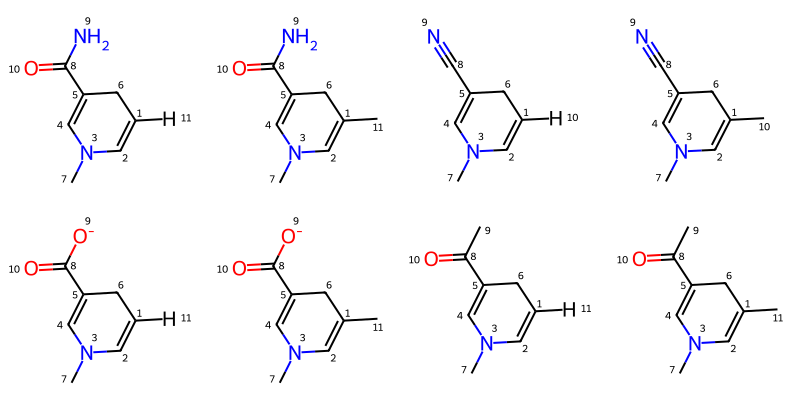

In [18]:
# defining a reaction to reduce the pyridinium cofactors
def reduction_rxn(mol):
    try:
        mol.GetAtomWithIdx(2).SetFormalCharge(0)
        mol.GetBondBetweenAtoms(1,2).SetBondType(rdkit.Chem.rdchem.BondType.SINGLE)
        mol.GetBondBetweenAtoms(2,3).SetBondType(rdkit.Chem.rdchem.BondType.SINGLE)
        mol.GetBondBetweenAtoms(4,5).SetBondType(rdkit.Chem.rdchem.BondType.SINGLE)
        mol.GetBondBetweenAtoms(0,5).SetBondType(rdkit.Chem.rdchem.BondType.SINGLE)
        mol.GetBondBetweenAtoms(3,4).SetBondType(rdkit.Chem.rdchem.BondType.DOUBLE)
        mol.GetBondBetweenAtoms(0,1).SetBondType(rdkit.Chem.rdchem.BondType.DOUBLE)
        Chem.SanitizeMol(mol)
    except:
        mol = None
    return mol

# reducing the biomimetic cofactors into reduced form
BMCs['red_mol'] = [reduction_rxn(x) for x in nicotinamides] # getting the mol object for RDKit
BMCs['red_smiles'] = BMCs['red_mol'].apply(lambda x: Chem.MolToSmiles(x)) # getting the SMILES string for starting calculations

# # reducing the natural cofactor analogs into reduced form
# natural['red_mol'] = [reduction_rxn(x) for x in nat_nicotinamides] # getting the mol object for RDKit
# natural['red_smiles'] = natural['red_mol'].apply(lambda x: Chem.MolToSmiles(x)) # getting the SMILES string for starting calculations

# visualizing new reduced cofactors
Draw.MolsToGridImage(BMCs['red_mol'][0:8],molsPerRow=4) # includes atom numbering

#### Adding our Reduced Natural Cofactors to a Dataframe

,code_name,SMILES,charge,multiplicity,unpaired,ROMol
0,NMNH_1-_reduced,[H]C1=CN([C@@H]2O[C@H](COP(=O)([O-])O)[C@@H](O...,-1,1,0,
1,NMNH_2-_reduced,[H]C1=CN([C@@H]2O[C@H](COP(=O)([O-])[O-])[C@@H...,-2,1,0,

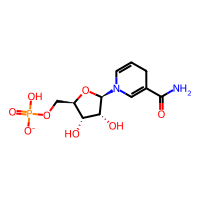
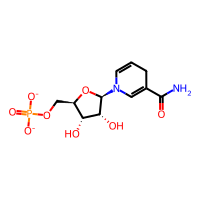

In [11]:
# # Save to a pandas dataframe that we can manipulate before saving to csv
# natural_reduced = pd.DataFrame()

# # Generate IDs
# natural_reduced['code_name'] = ['NMNH_1-_reduced', 'NMNH_2-_reduced'] # common names since there are only two structures

# # Convert the nicotinamide mol objects to a list of smiles and grab the total charge/multiplicity/number of unpaired electrons
# natural_reduced['SMILES'] = [Chem.MolToSmiles(mol) for mol in natural['red_mol']]
# natural_reduced['charge'] = [Chem.rdmolops.GetFormalCharge(mol) for mol in natural['red_mol']]
# natural_reduced['multiplicity'] = [(Chem.Descriptors.NumRadicalElectrons(mol)+1) for mol in natural['red_mol']] 
# natural_reduced['unpaired'] = [(Chem.Descriptors.NumRadicalElectrons(mol)) for mol in natural['red_mol']]

# # This adds the mol object as a column - useful for visualization in Jupyter Notebooks
# PandasTools.AddMoleculeColumnToFrame(natural_reduced, smilesCol='SMILES')
# natural_reduced

#### Adding our Reduced BMCs to a Dataframe

,code_name,SMILES,charge,multiplicity,unpaired,ROMol
0,A1a,[H]C1=CN(C)C=C(C(N)=O)C1,0,1,0,
1,A1b,CC1=CN(C)C=C(C(N)=O)C1,0,1,0,
2,A2a,[H]C1=CN(C)C=C(C#N)C1,0,1,0,
3,A2b,CC1=CN(C)C=C(C#N)C1,0,1,0,
4,A5a,[H]C1=CN(C)C=C(C(=O)[O-])C1,-1,1,0,
...,...,...,...,...,...,...
127,I3b,CC(=O)C1=CN(CCCCCc2ccccc2)C=C(C)C1,0,1,0,
128,I4a,[H]C1=CN(CCCCCc2ccccc2)C=C(C=O)C1,0,1,0,
129,I4b,CC1=CN(CCCCCc2ccccc2)C=C(C=O)C1,0,1,0,
130,I6a,[H]C1=CN(CCCCCc2ccccc2)C=C(C(=O)OC)C1,0,1,0,

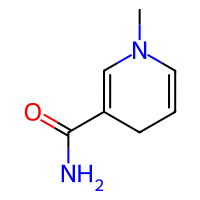
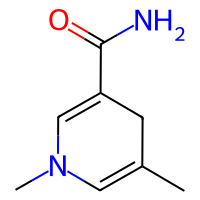
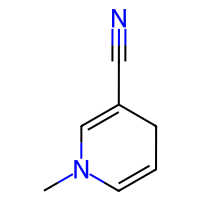
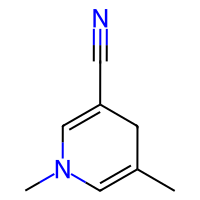
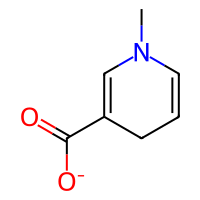
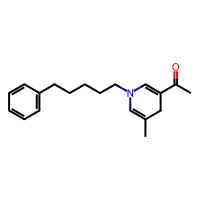
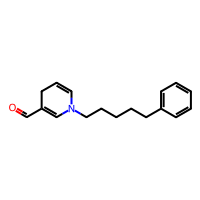
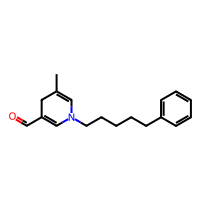
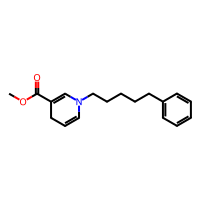
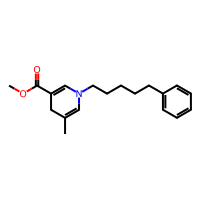

In [20]:
# Save to a pandas dataframe that we can manipulate before saving to csv
BMCs_reduced = pd.DataFrame()

# Generate IDs
# naming bmcs to match new convention
r1 = ['A','B','D','C','E','J','F','G','H','K','I'] # listing substituents in the order they appear in the list of SMILES strings
r2 = ['1','2','5','3','4','6']
r3 = ['a','b']

names = []

for i in r1:
    for j in r2:
        for k in r3:
            names.append(i + j + k)

BMCs_reduced['code_name'] = names

# Convert the nicotinamide mol objects to a list of smiles and grab the total charge/multiplicity/number of unpaired electrons
BMCs_reduced['SMILES'] = [Chem.MolToSmiles(mol) for mol in BMCs['red_mol']]
BMCs_reduced['charge'] = [Chem.rdmolops.GetFormalCharge(mol) for mol in BMCs['red_mol']]
BMCs_reduced['multiplicity'] = [(Chem.Descriptors.NumRadicalElectrons(mol)+1) for mol in BMCs['red_mol']] 
BMCs_reduced['unpaired'] = [(Chem.Descriptors.NumRadicalElectrons(mol)) for mol in BMCs['red_mol']]

# This adds the mol object as a column - useful for visualization in Jupyter Notebooks
PandasTools.AddMoleculeColumnToFrame(BMCs_reduced, smilesCol='SMILES')
BMCs_reduced

#### Adding Atom Numbers to the Images/Drawings of the Reduced BMCs

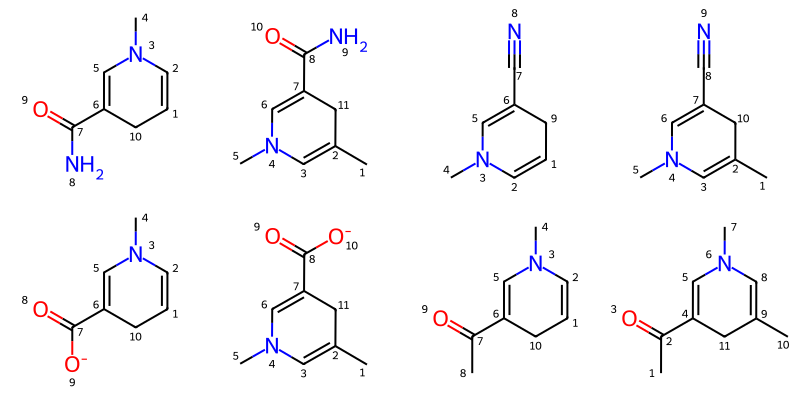

In [21]:
# Add atom numbers to the images
for mol in BMCs_reduced['ROMol']:
    for i, atom in enumerate(mol.GetAtoms()):
        # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
        atom.SetProp("atomNote", str(atom.GetIdx()+1))

Draw.MolsToGridImage(BMCs_reduced['ROMol'][0:8],molsPerRow=4)

#### Defining an Inactivation Reaction and Applying the Reaction to our Cofactors

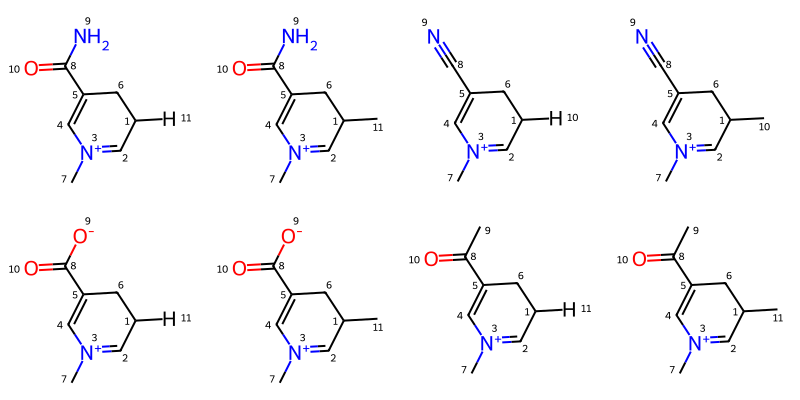

In [22]:
# defining a function to inactivate our bmcs
def inactivation_rxn(mol):
    try:
        mol.GetAtomWithIdx(2).SetFormalCharge(1)
        mol.GetBondBetweenAtoms(1,2).SetBondType(rdkit.Chem.rdchem.BondType.DOUBLE)
        mol.GetBondBetweenAtoms(0,1).SetBondType(rdkit.Chem.rdchem.BondType.SINGLE)
        Chem.SanitizeMol(mol)
    except:
        mol = None
    return mol

# applying to BMCs
BMCs['inact_mol'] = [inactivation_rxn(x) for x in nicotinamides] #inactivating cofactors
BMCs['inact_smiles'] = BMCs['inact_mol'].apply(lambda x: Chem.MolToSmiles(x)) # converting inactive structures to smiles strings

# # applying to natural analogs
# natural['inact_mol'] = [inactivation_rxn(x) for x in nat_nicotinamides]
# natural['inact_smiles'] = natural['inact_mol'].apply(lambda x: Chem.MolToSmiles(x))

# visualizing inactive BMCs
Draw.MolsToGridImage(BMCs['inact_mol'][0:8],molsPerRow=4)

#### Adding the Inactive Natural Cofactors to a Dataframe

,code_name,SMILES,charge,multiplicity,unpaired,ROMol
0,NMNH_1-_inactive,[H]C1C=[N+]([C@@H]2O[C@H](COP(=O)([O-])O)[C@@H...,0,1,0,
1,NMNH_2-_inactive,[H]C1C=[N+]([C@@H]2O[C@H](COP(=O)([O-])[O-])[C...,-1,1,0,

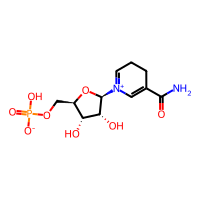
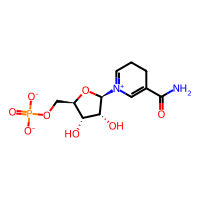

In [15]:
# natural_inact = pd.DataFrame()

# # Generate IDs
# natural_inact['code_name'] = ['NMNH_1-_inactive', 'NMNH_2-_inactive']

# # Convert the nicotinamide mol objects to a list of smiles and grab the total charge/multiplicity/number unpaired electrons
# natural_inact['SMILES'] = [Chem.MolToSmiles(mol) for mol in natural['inact_mol']]
# natural_inact['charge'] = [Chem.rdmolops.GetFormalCharge(mol) for mol in natural['inact_mol']]
# natural_inact['multiplicity'] = [(Chem.Descriptors.NumRadicalElectrons(mol)+1) for mol in natural['inact_mol']] 
# natural_inact['unpaired'] = [(Chem.Descriptors.NumRadicalElectrons(mol)) for mol in natural['inact_mol']]

# # This adds the mol object as a column - useful for visualization in Jupyter
# PandasTools.AddMoleculeColumnToFrame(natural_inact, smilesCol='SMILES')
# natural_inact

#### Adding the Inactive BMCs to a Dataframe

,code_name,SMILES,charge,multiplicity,unpaired,ROMol
0,A1a,[H]C1C=[N+](C)C=C(C(N)=O)C1,1,1,0,
1,A1b,CC1C=[N+](C)C=C(C(N)=O)C1,1,1,0,
2,A2a,[H]C1C=[N+](C)C=C(C#N)C1,1,1,0,
3,A2b,CC1C=[N+](C)C=C(C#N)C1,1,1,0,
4,A5a,[H]C1C=[N+](C)C=C(C(=O)[O-])C1,0,1,0,
...,...,...,...,...,...,...
127,I3b,CC(=O)C1=C[N+](CCCCCc2ccccc2)=CC(C)C1,1,1,0,
128,I4a,[H]C1C=[N+](CCCCCc2ccccc2)C=C(C=O)C1,1,1,0,
129,I4b,CC1C=[N+](CCCCCc2ccccc2)C=C(C=O)C1,1,1,0,
130,I6a,[H]C1C=[N+](CCCCCc2ccccc2)C=C(C(=O)OC)C1,1,1,0,

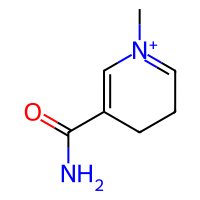
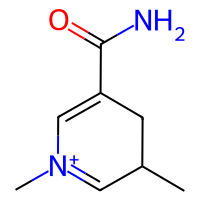
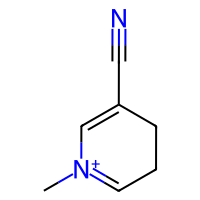
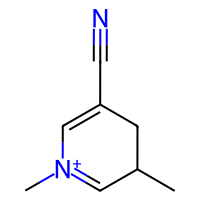
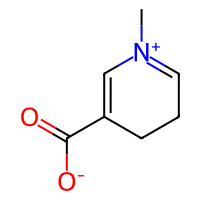
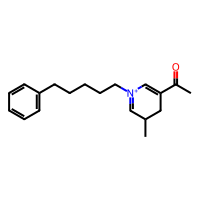
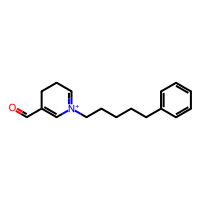
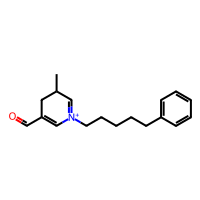
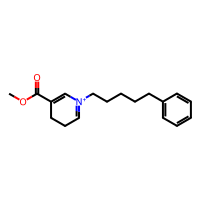
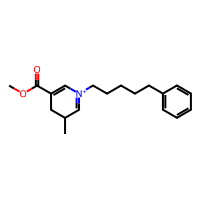

In [23]:
BMCs_inact = pd.DataFrame()

# # Generate IDs
# padding = 3
# BMCs_inact['code_name'] = ['BMC_'+str(str(i+1).zfill(padding)+'_inactive') for i in range(0,len(nicotinamides))] # for high-throughput

# naming bmcs to match new convention
r1 = ['A','B','D','C','E','J','F','G','H','K','I'] # listing substituents in the order they appear in the list of SMILES strings
r2 = ['1','2','5','3','4','6']
r3 = ['a','b']

names = []

for i in r1:
    for j in r2:
        for k in r3:
            names.append(i + j + k)

BMCs_inact['code_name'] = names

# Convert the nicotinamide mol objects to a list of smiles and grab the total charges
BMCs_inact['SMILES'] = [Chem.MolToSmiles(mol) for mol in BMCs['inact_mol']]
BMCs_inact['charge'] = [Chem.rdmolops.GetFormalCharge(mol) for mol in BMCs['inact_mol']]
BMCs_inact['multiplicity'] = [(Chem.Descriptors.NumRadicalElectrons(mol)+1) for mol in BMCs['inact_mol']] 
BMCs_inact['unpaired'] = [(Chem.Descriptors.NumRadicalElectrons(mol)) for mol in BMCs['inact_mol']]

# This adds the mol object as a column - useful for visualization in Jupyter
PandasTools.AddMoleculeColumnToFrame(BMCs_inact, smilesCol='SMILES')
BMCs_inact

#### Cleaning the Dataframes
Removing the mol objects before saving to a CSV

In [24]:
# Having visualized, easier to drop the mol objects before saving to CSV
# cleaning BMC dataframes
BMCs_pyr_clean = BMCs.drop(['ROMol'],axis=1)
BMCs_pyr_clean = BMCs_pyr_clean.drop(['red_mol'], axis=1)
BMCs_pyr_clean = BMCs_pyr_clean.drop(['red_smiles'], axis=1)
BMCs_pyr_clean = BMCs_pyr_clean.drop(['inact_mol'], axis=1)
BMCs_pyr_clean = BMCs_pyr_clean.drop(['inact_smiles'], axis=1)

BMCs_reduced_clean = BMCs_reduced.drop(['ROMol'], axis=1)
BMCs_inact_clean = BMCs_inact.drop(['ROMol'], axis=1)

# # cleaning natual analog dataframes
# natural_pyr_clean = natural.drop(['ROMol'], axis=1)
# natural_pyr_clean = natural_pyr_clean.drop(['red_mol'], axis=1)
# natural_pyr_clean = natural_pyr_clean.drop(['red_smiles'], axis=1)
# natural_pyr_clean = natural_pyr_clean.drop(['inact_mol'], axis=1)
# natural_pyr_clean = natural_pyr_clean.drop(['inact_smiles'], axis=1)

# natural_reduced_clean = natural_reduced.drop(['ROMol'], axis=1)
# natural_inact_clean = natural_inact.drop(['ROMol'], axis=1)

#### Compiling all BMCs into one Dataframe

In [18]:
# adding pyridinium, reduced, and inactive species to one dataframe
BMCs_all = pd.concat([BMCs_pyr_clean, BMCs_reduced_clean, BMCs_inact_clean], axis=0, ignore_index=True)
BMCs_all.to_csv('generated_bmcs.csv') #option to save only BMCs to a csv

#### Compiling all Cofactors into one Dataframe and Saving as a CSV

In [19]:
# # adding pyridinium, reduced, and inactive natural analogs to all BMC dataframe
# cofactors_natural = pd.concat([natural_pyr_clean, natural_reduced_clean, natural_inact_clean], axis=0, ignore_index=True)
# cofactors_natural.to_csv('generated_bmcs_natural.csv') #option to save all structures to a csv

# cofactors_all = pd.concat([cofactors_natural,BMCs_all], axis=0, ignore_index=True)
# cofactors_all.to_csv('generated_bmcs_all.csv')

#### Creating a file to help with the CENSO / AQME Calculations

In [20]:
# creating a datagrame with necessary column names
censo_aqme_files = pd.DataFrame(columns=['for_censo_filename', 'for_cregen_filename', 'charge', 'multiplicity', 'unpaired', 'for_crest_input_filename', 'for_qprep_filename', 'ignore'])

# filenames that need to be called to run censo (crest ensemble files)
censo_aqme_files['for_censo_filename'] = BMCs_all['code_name']+'_crest.xyz' # $1 in bash

# filenames that need to be called to run cregen clustering (censo ensemble files)
censo_aqme_files['for_cregen_filename'] = BMCs_all['code_name']+'_censo_ensemble.xyz' # $2 in bash

# charge of each cofactor to be called in crest/censo/cregen/aqme-qprep
censo_aqme_files['charge'] = BMCs_all['charge'] # $3 in bash

# multiplicity of each cofactor to be called in crest/censo/cregen/aqme-qprep
censo_aqme_files['multiplicity'] = BMCs_all['multiplicity'] # $4 in bash

# number of unpaired electrons to be called in crest/censo/cregen/aqme-qprep
censo_aqme_files['unpaired'] = BMCs_all['multiplicity'] - 1 # $5 in bash

# filename to be called for crest (xTB optimized structure)
censo_aqme_files['for_crest_input_filename'] = BMCs_all['code_name']+'_crest_xtb1.xyz' # $6 in bash

# filename to be called to aqme-qprep (clustered ensemble files)
censo_aqme_files['for_qprep_filename'] = BMCs_all['code_name']+'_censo_ensemble_clustered.xyz' # $7 in bash

# ignored column to help the bash script read things in properly
censo_aqme_files['ignore'] = BMCs_all['multiplicity'] # $8 in bash

# saving as a csv separated by whitespace instead of commas
# removing heading titles for easier reading in bash
censo_aqme_files.to_csv('censo_assist_bmcs.csv',sep=' ', index=False, header=False)